# In the Name of God
## Deep Learning HW4 - Problem 2
## Sayed Pouria fatemi 400206324


<div dir="rtl"> <font size="4" face="vazirmatn">    
برای این سوال از سایت 

https://medium.com/analytics-vidhya/use-pytorch-to-create-an-image-captioning-model-with-cnn-and-seq2seq-lstm-and-train-on-google-e6563cb9f511

کمک گرفته شده است.
</font> </div> 

In [1]:
import os 
import sys
from pycocotools.coco import COCO
import urllib
import zipfile 
import matplotlib.pyplot as plt 
import skimage.io as io 
import numpy as np 
import nltk
import pickle
from collections import Counter
import torch
import torch.utils.data as data
from PIL import Image
from tqdm import tqdm
import random
import json
nltk.download('punkt')
from torchvision import transforms
import torch.nn as nn
import math
import matplotlib.pyplot as plt 
import torchvision.models as models
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [19]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [4]:
os.makedirs('opt')
os.chdir( '/content/opt' )
!git clone 'https://github.com/cocodataset/cocoapi.git'

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 20.28 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [5]:
os.chdir('/content/opt/cocoapi')

annotations_trainval2017 = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
image_info_test2017 = 'http://images.cocodataset.org/annotations/image_info_test2017.zip'

urllib.request.urlretrieve(annotations_trainval2017 , filename = 'annotations_trainval2017.zip' )
urllib.request.urlretrieve(image_info_test2017 , filename= 'image_info_test2017.zip' )

('image_info_test2017.zip', <http.client.HTTPMessage at 0x7f0f97c5b4f0>)

In [6]:
!unzip '/content/opt/cocoapi/annotations_trainval2017.zip'
!rm -rf '/content/opt/cocoapi/annotations_trainval2017.zip'
!unzip '/content/opt/cocoapi/image_info_test2017.zip'
!rm -rf '/content/opt/cocoapi/image_info_test2017.zip'

Archive:  /content/opt/cocoapi/annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  
Archive:  /content/opt/cocoapi/image_info_test2017.zip
  inflating: annotations/image_info_test-dev2017.json  
  inflating: annotations/image_info_test2017.json  


In [7]:
os.chdir('/content/opt/cocoapi/annotations')

dataType = 'val2017'
instances_annFile = 'instances_{}.json'.format(dataType)
print(instances_annFile)
coco = COCO(instances_annFile)

captions_annFile = 'captions_{}.json'.format(dataType)
coco_caps = COCO(captions_annFile)

ids = list(coco.anns.keys())

instances_val2017.json
loading annotations into memory...
Done (t=0.93s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [27]:
os.chdir('/content/opt/cocoapi')

train2017 = 'http://images.cocodataset.org/zips/train2017.zip'
test2017 = 'http://images.cocodataset.org/zips/test2017.zip'

urllib.request.urlretrieve( train2017 , 'train2017.zip' )
urllib.request.urlretrieve( test2017 , 'test2017.zip' )

('train2017.zip', <http.client.HTTPMessage at 0x7f0ec1eb5d30>)

In [28]:
!unzip -q '/content/opt/cocoapi/train2017.zip'
!rm -rf '/content/opt/cocoapi/train2017.zip'
!unzip -q '/content/opt/cocoapi/test2017.zip'
!rm -rf '/content/opt/cocoapi/test2017.zip'

## DataLoader

In [12]:
class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='../cocoapi/annotations/captions_train2017.json',
        vocab_from_file=False):
      
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):

        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):

        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):

        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):

        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):

        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [13]:
def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc='/opt'):
    
    if mode == 'train':
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/train2017/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_train2017.json')
    if mode == 'test':
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/test2017/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/image_info_test2017.json')

    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    if mode == 'train':
        indices = dataset.get_train_indices()
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader

class CoCoDataset(data.Dataset):
    
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':            
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
        
    def __getitem__(self, index):
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            return image, caption

        else:
            path = self.paths[index]

            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

In [29]:
transform_train = transforms.Compose([ 
    transforms.Resize((224,224)),                          
    transforms.RandomHorizontalFlip(),               
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

vocab_threshold = 8
batch_size = 200
data_loader_train = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False,
                         cocoapi_loc = '/content/opt')

loading annotations into memory...
Done (t=1.20s)
creating index...
index created!
[0/591753] Tokenizing captions...
[100000/591753] Tokenizing captions...
[200000/591753] Tokenizing captions...
[300000/591753] Tokenizing captions...
[400000/591753] Tokenizing captions...
[500000/591753] Tokenizing captions...
loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [01:01<00:00, 9659.69it/s]


## CNN Encoder



In [14]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)        
        features = features.view(features.size(0), -1)        
        features = self.embed(features)        
        return features
    

## RNN Decoder

In [15]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super( DecoderRNN , self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size 
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.word_embedding = nn.Embedding( self.vocab_size , self.embed_size )
        self.lstm  = nn.LSTM(    input_size  =  self.embed_size , 
                             hidden_size = self.hidden_size,
                             num_layers  = self.num_layers ,
                             batch_first = True 
                             )
        self.fc = nn.Linear( self.hidden_size , self.vocab_size  )
        

    def init_hidden( self, batch_size ):
      return ( torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device),
      torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device) )
    
    def forward(self, features, captions):            
      captions = captions[:,:-1]      
      self.batch_size = features.shape[0]
      self.hidden = self.init_hidden( self.batch_size )
      embeds = self.word_embedding( captions )
      inputs = torch.cat( ( features.unsqueeze(dim=1) , embeds ) , dim =1  )      
      lstm_out , self.hidden = self.lstm(inputs , self.hidden)      
      outputs = self.fc( lstm_out )      
      return outputs

    def Predict(self, inputs, max_len=20):        
        final_output = []
        batch_size = inputs.shape[0]         
        hidden = self.init_hidden(batch_size) 
    
        while True:
            lstm_out, hidden = self.lstm(inputs, hidden) 
            outputs = self.fc(lstm_out)  
            outputs = outputs.squeeze(1) 
            _, max_idx = torch.max(outputs, dim=1) 
            final_output.append(max_idx.cpu().numpy()[0].item())             
            if (max_idx == 1 or len(final_output) >=20 ):
                break
            
            inputs = self.word_embedding(max_idx) 
            inputs = inputs.unsqueeze(1)             
        return final_output  

## Learning

In [ ]:
embed_size = 256
hidden_size = 100
num_layers =1 
num_epochs = 3
print_every = 150
save_every = 20
vocab_size = len(data_loader_train.dataset.vocab)
total_step = math.ceil( len(data_loader_train.dataset.caption_lengths) / data_loader_train.batch_sampler.batch_size   )

encoder = EncoderCNN( embed_size )
encoder.to(device)

decoder = DecoderRNN(  embed_size , hidden_size, vocab_size ,num_layers)
criterion = nn.CrossEntropyLoss()
lr = 0.001
all_params = list(decoder.parameters())  + list( encoder.embed.parameters() )
optimizer = torch.optim.Adam( params  = all_params , lr = lr  )



device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_save_path = '/content/drive/My Drive/Colab Notebooks/ComputerVision/RNN_LSTM/image_caption/CVND---Image-Captioning-Project/checkpoint'
os.makedirs( model_save_path , exist_ok=True)

decoder_input_params = {'embed_size' : embed_size , 
                'hidden_size' : hidden_size , 
                'num_layers' : num_layers,
                'lr' : lr ,
                'vocab_size' : vocab_size
                }

with open(  os.path.join(model_save_path , 'decoder_input_params_12_20_2019.pickle'), 'wb') as handle:
    pickle.dump(decoder_input_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
for e in range(num_epochs):
  for step in range(total_step):
    indices = data_loader_train.dataset.get_train_indices()
    new_sampler = data.sampler.SubsetRandomSampler( indices )
    data_loader_train.batch_sampler.sampler = new_sampler    
    images,captions = next(iter(data_loader_train))    
    images , captions = images.to(device) , captions.to(device)
    encoder , decoder = encoder.to(device) , decoder.to(device)
    encoder.zero_grad()    
    decoder.zero_grad()
    features = encoder(images)
    output = decoder( features , captions )    
    loss = criterion( output.view(-1, vocab_size) , captions.view(-1) )
    loss.backward()
    optimizer.step()
    stat_vals = 'Epochs [%d/%d] Step [%d/%d] Loss [%.4f] ' %( e+1,num_epochs,step,total_step,loss.item() )
    if step % print_every == 0 :
      print(stat_vals)
      sys.stdout.flush()
    if e % save_every == 0:
      torch.save( encoder.state_dict() ,  os.path.join( model_save_path , 'encoderdata_{}.pkl'.format(e+1) ) )
      torch.save( decoder.state_dict() ,  os.path.join( model_save_path , 'decoderdata_{}.pkl'.format(e+1) ) )


Epochs [1/3] Step [0/2959] Loss [9.0164] 
Epochs [1/3] Step [150/2959] Loss [4.0110] 
Epochs [1/3] Step [300/2959] Loss [4.0787] 
Epochs [1/3] Step [450/2959] Loss [3.3980] 
Epochs [1/3] Step [600/2959] Loss [3.1862] 
Epochs [1/3] Step [750/2959] Loss [3.6598] 
Epochs [1/3] Step [900/2959] Loss [3.0280] 
Epochs [1/3] Step [1050/2959] Loss [3.0473] 
Epochs [1/3] Step [1200/2959] Loss [3.0451] 
Epochs [1/3] Step [1350/2959] Loss [2.9093] 
Epochs [1/3] Step [1500/2959] Loss [2.7904] 
Epochs [1/3] Step [1650/2959] Loss [2.8209] 
Epochs [1/3] Step [1800/2959] Loss [2.6872] 
Epochs [1/3] Step [1950/2959] Loss [2.9913] 
Epochs [1/3] Step [2100/2959] Loss [2.7338] 
Epochs [1/3] Step [2250/2959] Loss [2.6289] 
Epochs [1/3] Step [2400/2959] Loss [2.7329] 
Epochs [1/3] Step [2550/2959] Loss [2.5779] 
Epochs [1/3] Step [2700/2959] Loss [2.5298] 
Epochs [1/3] Step [2850/2959] Loss [2.4724] 
Epochs [2/3] Step [0/2959] Loss [2.6787] 
Epochs [2/3] Step [150/2959] Loss [2.4683] 
Epochs [2/3] Step [300/

## Predict

In [21]:
model_save_path = '/content/drive/My Drive/Colab Notebooks/ComputerVision/RNN_LSTM/image_caption/CVND---Image-Captioning-Project/checkpoint'
os.makedirs( model_save_path , exist_ok=True)

with open(  os.path.join(model_save_path , 'decoder_input_params_12_20_2019.pickle'), 'rb') as handle:
    decoder_input_params = pickle.load(handle)

embed_size = decoder_input_params['embed_size']
hidden_size= decoder_input_params['hidden_size']
vocab_size = decoder_input_params['vocab_size']
num_layers = decoder_input_params['num_layers']

encoder = EncoderCNN( embed_size )
encoder.load_state_dict(   torch.load(  os.path.join( model_save_path , 'encoderdata_{}.pkl'.format(1) )   ) )

decoder = DecoderRNN( embed_size , hidden_size , vocab_size , num_layers )
decoder.load_state_dict( torch.load(   os.path.join( model_save_path , 'decoderdata_{}.pkl'.format(1) )   ) )



/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<All keys matched successfully>

In [31]:
transform_test = transforms.Compose([ 
    transforms.Resize((224,224)),                          
    transforms.RandomHorizontalFlip(),               
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

data_loader_test = get_loader(transform=transform_test,
                         mode='test',                         
                         cocoapi_loc = '/content/opt')

data_iter = iter(data_loader_test)

Vocabulary successfully loaded from vocab.pkl file!


In [32]:
def get_sentences( original_img, all_predictions ):
  sentence = ' '
  plt.imshow(original_img.squeeze())
  return sentence.join([data_loader_test.dataset.vocab.idx2word[idx] for idx in all_predictions[1:-1] ]  )

'a plate of food with a sandwich and a fork .'

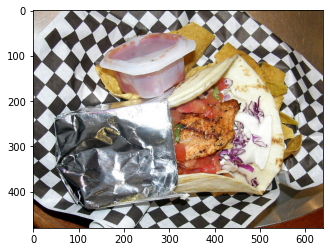

In [46]:
encoder.to(device) 
decoder.to(device)
encoder.eval()
decoder.eval()
original_img , processed_img  = next( data_iter )

features  = encoder(processed_img.to(device)   ).unsqueeze(1)
final_output = decoder.Predict( features  , max_len=20)
get_sentences(original_img, final_output)